In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
import warnings
warnings.filterwarnings("ignore")   # отключает предупреждения

# считываю файл csv

In [ ]:
data = pd.read_csv('/content/output_river.csv').drop('Unnamed: 0', axis = 1) # делаю drop первой колонки
data.head(3)

,journal,title,ISSN,DOI,authors,affilations,date,pages,abstract,raw_url,keywords
0,International Journal of Fluid Power,Novel concept for stabilising a hydraulic circ...,2332-1180,10.1080/14399776.2016.1172446,"['Jesper K. Sørensen', 'Michael R. Hansen', 'M...","['Faculty of Engineering and Science, Departme...",2016-11-01,NaN,"In this paper, a novel concept for stabilising...",https://journals.riverpublishers.com/index.php...,"['Oscillations', 'counterbalance valve', 'pres..."
1,International Journal of Fluid Power,Open-loop Independent Metering Control of a Mu...,2332-1180,10.13052/ijfp1439-9776.2121,"['Mikko Huova', 'Jyrki Tammisto', 'Matti Li...",['Automation Technology and Mechanical Enginee...,2020-11-04,147–168,This study applies independent metering contro...,https://journals.riverpublishers.com/index.php...,"['independent metering', 'forwarder', 'energy ..."
2,International Journal of Fluid Power,Modelling and experimental validation of the d...,2332-1180,10.1080/14399776.2016.1160718,"['Anthony L. Knutson', 'James D. Van de Ven']","['Department of Mechanical Engineering, Univer...",2016-08-01,114-124,A variety of methods have previously been appl...,https://journals.riverpublishers.com/index.php...,"['Hydraulic valve', 'check valve', 'laser tria..."


In [ ]:
data['affilations'][0]   # хранится str

"['Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway', 'Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway', 'Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway']"

# меняю формат кононки affilations

In [ ]:
import ast

In [ ]:
data['affilations'] = data['affilations'].apply(lambda x: ast.literal_eval(x))  # из строки делаю список строк

In [ ]:
data['affilations'] = data['affilations'].apply(lambda x: list(map(lambda y: y.strip(), x)))  # очищаю строки от пробелов по краям

In [ ]:
data['affilations'] = data['affilations'].apply(lambda x: list(set(x)))   # удаляю повторяющиеся аффиляции

In [ ]:
data['affilations'][0]

['Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway']

In [ ]:
data.isna().sum()   # с аффиляциями все в порядке

journal         0
title           0
ISSN            0
DOI            72
authors         0
affilations     0
date            0
pages          21
abstract        0
raw_url         0
keywords        0
dtype: int64

In [ ]:
import seaborn as sns

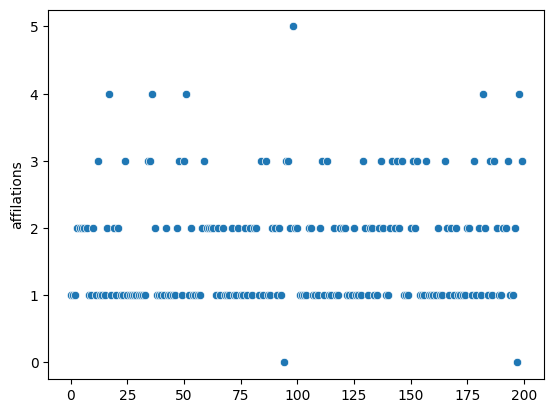

In [ ]:
sns.scatterplot(data['affilations'].apply(len));  # диаграмма рассеивания количества аффиляций в статьях

In [ ]:
data[data['affilations'].map(len) == 0]

,journal,title,ISSN,DOI,authors,affilations,date,pages,abstract,raw_url,keywords
94,International Journal of Fluid Power,Foreword,2332-1180,NaN,['Fedor Nazarov'],[],2021-11-20,1-1,The 17th Scandinavian International Conference...,https://journals.riverpublishers.com/index.php...,['Foreword']
197,International Journal of Fluid Power,Editorial,2332-1180,NaN,"['Jarosław Stryczek', 'Urszula Warzyńska']",[],2021-02-06,NaN,Polish fluid power conference has been held in...,https://journals.riverpublishers.com/index.php...,['Editorial']


In [ ]:
data.drop(data[data['affilations'].map(len) == 0].index, inplace=True)   # убираю строки без аффиляций

# создаю общий список всех аффиляций

In [ ]:
af = list(np.concatenate(list(data['affilations'])).flat); af[:9]

['Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway',
 'Automation Technology and Mechanical Engineering, Tampere University, Korkeakoulunkatu 6, FI-33720, Tampere, Finland',
 'Department of Mechanical Engineering, University of Minnesota, Minneapolis, MN, USA',
 'Universidade da Coruña, Centro de Investigación CITIC, Facultade de Informática, A Coruña, Spain',
 'Enxenio S.L., A Coruña, Spain',
 'Northern Arizona University - M.E. Department, 15600 S. McConnell Dr., Flagstaff, Arizona 86001',
 'The University of Toledo - M.I.M.E. Department, 2801 W. Bancroft St., Toledo, Ohio 43606',
 'Laboratory of Automation and Hydraulic Engineering (AUT ), Tampere University of Technology (TUT), Tampere, Finland',
 'Department of Engineering Design and Production, Aalto University, Espoo, Finland']

In [ ]:
len(af)

333

## модели

# 1-я модель – k-means

Извлечение признаков TF-IDF – указывают, насколько важно слово для понимания документа или набора данных.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')  # RegexpTokenizer разбивает строку на подстроки, используя регулярное выражение.

In [ ]:
tf_idf_vect = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1, 2),     # будут использоваться униграммы и биаграммы
                        tokenizer = tokenizer.tokenize)

In [ ]:
X_train_counts = tf_idf_vect.fit_transform(af)

In [ ]:
X_train_counts.shape   # 2609 признаков

(333, 2609)

Наиболее простой метод кластеризации в классической реализации. Он разбивает множество элементов векторного пространства на заранее заданное число кластеров k. \

Действие алгоритма такое: он стремится минимизировать среднеквадратичное отклонение на точках каждого кластера. Основная идея заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге. Далее векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике. \

Алгоритм завершается, когда на какой-то итерации не происходит изменения кластеров.

In [ ]:
%%time
kmeans = KMeans(n_clusters=250).fit(X_train_counts)

CPU times: user 4.05 s, sys: 0 ns, total: 4.05 s
Wall time: 5.7 s


**Подберу наиболее гармоничное значение k, отслеживая метрики DBI score и коэффициент силуэта.**

In [ ]:
list_ss = []
for k in range(130, 333, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5).fit(X_train_counts)
    pred_labels = kmeans.labels_
    ss = metrics.silhouette_score(X_train_counts.toarray(), pred_labels, metric='euclidean')   # подсчет Silhoutte Score
    list_ss.append(ss)

Text(0, 0.5, 'Silhouette score')

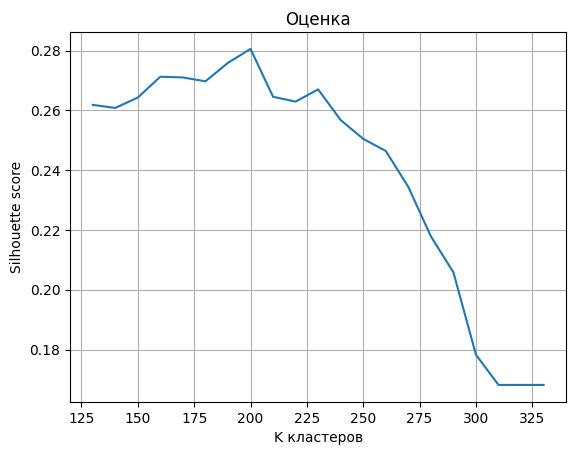

In [ ]:
plt.plot(range(130, 333, 10), list_ss)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('Silhouette score')

**Пересчитываю лучшую метрику с шагом 1 при k в интервале от 195 до 205 с большим значением n_init**

In [ ]:
list_ss = []
list_dbi = []
for k in range(195, 211):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10).fit(X_train_counts)
    pred_labels = kmeans.labels_
    ss = metrics.silhouette_score(X_train_counts.toarray(), pred_labels, metric='euclidean')   # подсчет Silhoutte Score
    dbi = metrics.davies_bouldin_score(X_train_counts.toarray(), pred_labels)                # подсчет DBI score
    list_ss.append(ss)
    list_dbi.append(dbi)

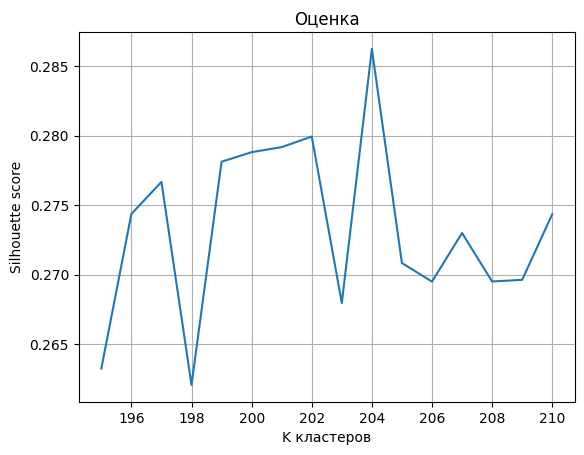

In [ ]:
plt.plot(range(195, 211), list_ss)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('Silhouette score');

Коэффициент силуэта рассчитывается с использованием среднего внутрикластерного расстояния (a) и среднего расстояния между ближайшими кластерами (b) для каждого образца. Коэффициент силуэта для выборки равен (b - a) / max(a, b). Для пояснения, b - это расстояние между образцом и ближайшим кластером, в который он не входит. \
Наилучшее значение равно 1, а наихудшее -1.

Более низкие значения DBI Score указывают на лучшую кластеризацию.



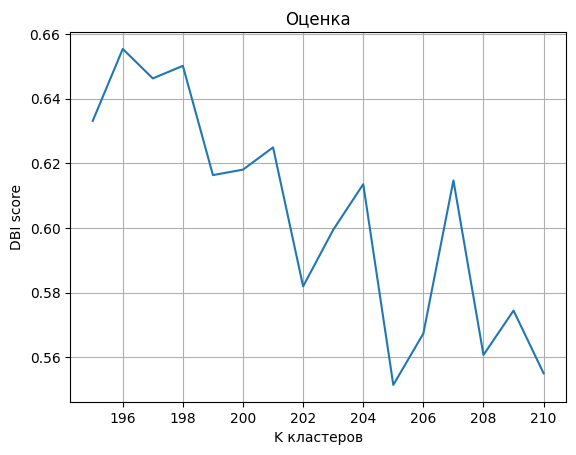

In [ ]:
plt.plot(range(195, 211), list_dbi)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('DBI score')
print('Более низкие значения DBI Score указывают на лучшую кластеризацию.')
print()

Из графиков видно, что наиболее точная кластеризация происходит при k = 204. Построим финальную модель с этим значением параметра.

In [ ]:
kmeans = KMeans(n_clusters=204, init='k-means++', n_init=10).fit(X_train_counts)
pred_labels = kmeans.labels_

In [ ]:
pred_labels.shape[0]

333

In [ ]:
pairs = dict(zip(af, pred_labels))

In [ ]:
import itertools
dict(itertools.islice(pairs.items(), 3))

{'Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway': 110,
 'Automation Technology and Mechanical Engineering, Tampere University, Korkeakoulunkatu 6, FI-33720, Tampere, Finland': 191,
 'Department of Mechanical Engineering, University of Minnesota, Minneapolis, MN, USA': 22}

In [ ]:
data['labels k-means'] = data['affilations'].apply(lambda x: list(set([*map(pairs.get, x)])))

In [ ]:
data.iloc[:, [1, 5, 11]].head(15)   # лейблы кластеров проставлены

,title,affilations,labels k-means
0,Novel concept for stabilising a hydraulic circ...,"[Faculty of Engineering and Science, Departmen...",[110]
1,Open-loop Independent Metering Control of a Mu...,[Automation Technology and Mechanical Engineer...,[191]
2,Modelling and experimental validation of the d...,"[Department of Mechanical Engineering, Univers...",[22]
3,Applying Feature-Oriented Software Development...,"[Universidade da Coruña, Centro de Investigaci...","[80, 149]"
4,DESIGN ANALYSIS AND CONTROL OF A MAGNETORHEOLO...,[Northern Arizona University - M.E. Department...,"[43, 157]"
5,Digital hydraulic multi-pressure actuator – th...,[Laboratory of Automation and Hydraulic Engine...,"[193, 159]"
6,REDUCING INFLUENCE OF ECCENTRIC LOAD ON DYNAMI...,"[SMC pneumatic technical Center, Mechanical En...",[36]
7,Model-Driven Skills Assessment in Knowledge Ma...,"[EVAL for Research Group, University of Cadiz,...","[163, 86]"
8,Method for combining valves with symmetric and...,"[LASHIP, Department of Mechanical Engineering,...",[33]
9,APPLICATION OF EXTENDED KALMAN FILTER IN A MET...,"[Rolf Fluid Power Lab, Mechanical and Aerospac...",[29]


In [ ]:
from collections import Counter

In [ ]:
# кол-во элементов в каждом кластере
d = Counter(sorted(list(np.concatenate(list(data['labels k-means'])).flat)))
dict(itertools.islice(d.items(), 15))

{0: 2,
 1: 2,
 2: 1,
 3: 1,
 4: 3,
 5: 3,
 6: 2,
 7: 4,
 8: 5,
 9: 2,
 10: 1,
 11: 2,
 12: 2,
 13: 8,
 14: 1}

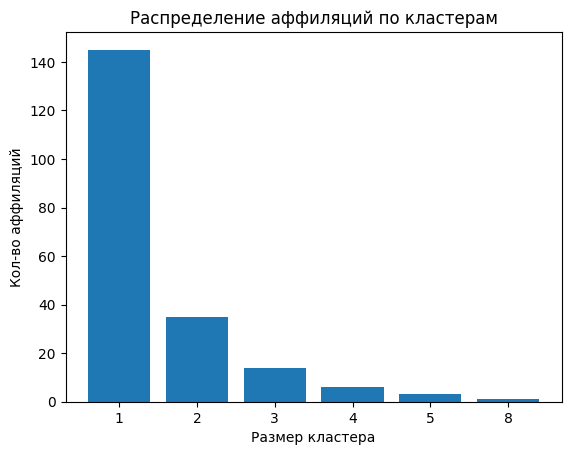

In [ ]:
dd = Counter(d.values())
dd = dict(sorted(dd.items()))
names = list(dd.keys())
values = list(dd.values())

plt.bar(range(len(dd)), values, tick_label=names)
plt.title('Распределение аффиляций по кластерам')
plt.xlabel('Размер кластера')
plt.ylabel('Кол-во аффиляций')
plt.show()

**Модель k-means позволила успешно и достаточно точно разбить аффиляции на 204 кластера.**

# 2-я модель – SpectralClustering

**Спектральная кластеризация выполняет низкоразмерное вложение матрицы сродства между выборками.**

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(af)

In [ ]:
# Обучим модель и замерим время обучения
%%time
model = SpectralClustering(n_clusters = 204)
model.fit(X)
labels = model.labels_
labels

CPU times: user 1.82 s, sys: 1.01 s, total: 2.82 s
Wall time: 1.47 s


array([ 60, 112,  98,  44,  85,  93,  40, 195, 178,  39,  39, 135, 133,
       181,  24, 149, 158,  19, 129, 172,  17,   8,  89,  10,  38,   4,
       108, 150, 145, 103, 193, 123,   5, 197, 153,  27, 154,  17, 169,
       127,   2,  37,  10, 180,  83, 186, 171,  43,  10,  19,  21,  21,
        21, 115, 184,  57,  22,  95,  22, 203, 104, 163, 151, 142, 190,
       129,  45,   1,  17,  39, 110,  33,  46,  64,  23,  91,   3, 199,
         3,   3,  91,  48,  47,  13,  30, 185,  36,  94,  26,  51,  86,
       198,  78, 188,  20,  20,   0, 159, 106,  96, 147, 161, 111,  69,
       155, 168, 167, 157,  75, 141, 120,  38, 188,  32,  38,   4,  43,
        37, 201,  23,  22, 128, 162, 164,  18,  24, 136, 124,  45,   1,
        13,  30,  82,   6, 122,  58,   6, 145, 145, 145,  89, 191,  49,
       121,   2,  32,   6,   6,  63, 156,  28,  84,  14,  55,  55, 202,
       137,   5, 176,  68, 116, 176,  68,  34,  34,  90, 107, 185,  86,
        59,  42,  58,  63,  80, 156,  88, 168,   2,  33, 152,  7

In [ ]:
labels.shape

(333,)

**Модель обучается в 3,5 раза быстрее модели k-means.**

In [ ]:
ss = metrics.silhouette_score(X, labels, metric='euclidean'); ss

0.3036051039130313

**На первый взгляд, модель подходящая, так как значение коэффициента силуэта высокое. Подберем теперь наилучшее значение количества кластеров.**

In [ ]:
list_ss = []
for k in range(100, 333, 10):
    model = SpectralClustering(n_clusters = k).fit(X)
    pred_labels = model.labels_
    ss = metrics.silhouette_score(X, pred_labels, metric='euclidean')   # подсчет Silhoutte Score
    list_ss.append(ss)

Text(0, 0.5, 'Silhouette score')

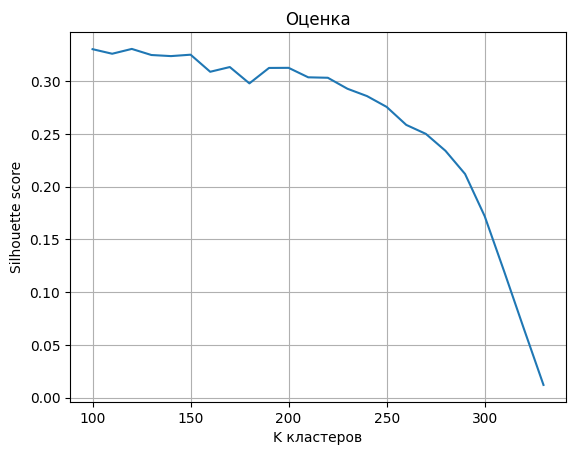

In [ ]:
plt.plot(range(100, 333, 10), list_ss)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('Silhouette score')

**Из графика выходит, что чем меньше кластеров, тем точнее работает модель. Проведем более подробное итерирование.**

In [ ]:
list_ss = []
list_dbi = []
for k in range(100, 210, 2):
    model = SpectralClustering(n_clusters = k).fit(X)
    pred_labels = model.labels_
    ss = metrics.silhouette_score(X, pred_labels, metric='euclidean')          # подсчет Silhoutte Score
    dbi = metrics.davies_bouldin_score(X_train_counts.toarray(), pred_labels)   # подсчет DBI score
    list_ss.append(ss)
    list_dbi.append(dbi)

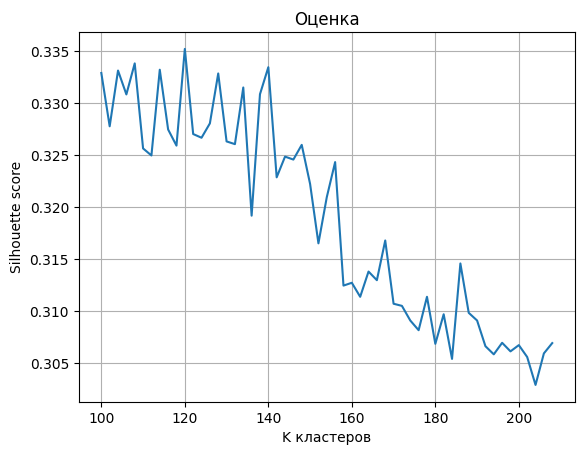

In [ ]:
plt.plot(range(100, 210, 2), list_ss)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('Silhouette score');

**Значение коэффициента силуэта держится в интервале (0,3; 0,335) от 100 кластеров до 210. Это значит, что к данной задаче модель следует применять в совокупности с другими моделями.**

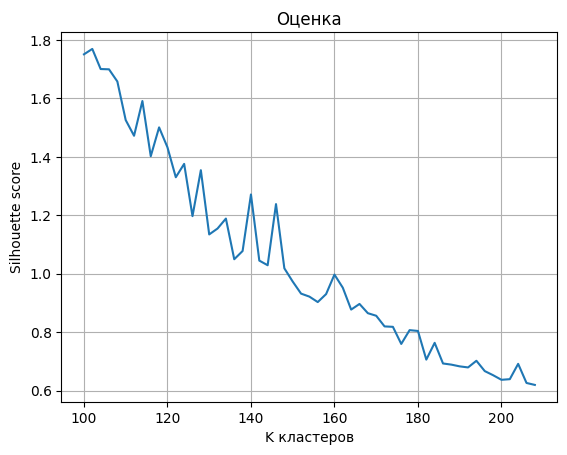

In [ ]:
plt.plot(range(100, 210, 2), list_dbi)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('Silhouette score');

**Метрика DBI ведет себя как положено.**

**Построим финальную модель SpectralClustering**

In [ ]:
model = SpectralClustering(n_clusters = 156).fit(X)
pred_labels = model.labels_

In [ ]:
pairs = dict(zip(af, pred_labels))

In [ ]:
import itertools
dict(itertools.islice(pairs.items(), 3))

{'Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway': 5,
 'Automation Technology and Mechanical Engineering, Tampere University, Korkeakoulunkatu 6, FI-33720, Tampere, Finland': 42,
 'Department of Mechanical Engineering, University of Minnesota, Minneapolis, MN, USA': 70}

In [ ]:
data['labels Spectral'] = data['affilations'].apply(lambda x: list(set([*map(pairs.get, x)])))

In [ ]:
data.iloc[:, [1, 5, 12]].head(15)   # лейблы кластеров проставлены

,title,affilations,labels Spectral
0,Novel concept for stabilising a hydraulic circ...,"[Faculty of Engineering and Science, Departmen...",[5]
1,Open-loop Independent Metering Control of a Mu...,[Automation Technology and Mechanical Engineer...,[42]
2,Modelling and experimental validation of the d...,"[Department of Mechanical Engineering, Univers...",[70]
3,Applying Feature-Oriented Software Development...,"[Universidade da Coruña, Centro de Investigaci...",[60]
4,DESIGN ANALYSIS AND CONTROL OF A MAGNETORHEOLO...,[Northern Arizona University - M.E. Department...,"[67, 83]"
5,Digital hydraulic multi-pressure actuator – th...,[Laboratory of Automation and Hydraulic Engine...,"[42, 79]"
6,REDUCING INFLUENCE OF ECCENTRIC LOAD ON DYNAMI...,"[SMC pneumatic technical Center, Mechanical En...",[36]
7,Model-Driven Skills Assessment in Knowledge Ma...,"[EVAL for Research Group, University of Cadiz,...",[91]
8,Method for combining valves with symmetric and...,"[LASHIP, Department of Mechanical Engineering,...",[73]
9,APPLICATION OF EXTENDED KALMAN FILTER IN A MET...,"[Rolf Fluid Power Lab, Mechanical and Aerospac...",[57]


In [ ]:
# кол-во элементов в каждом кластере
d = Counter(sorted(list(np.concatenate(list(data['labels Spectral'])).flat)))
dict(itertools.islice(d.items(), 20))

{0: 2,
 1: 9,
 2: 1,
 3: 6,
 4: 1,
 5: 4,
 6: 2,
 7: 1,
 8: 5,
 9: 3,
 10: 3,
 11: 4,
 12: 7,
 13: 2,
 14: 8,
 15: 1,
 16: 3,
 17: 4,
 18: 2,
 19: 5}

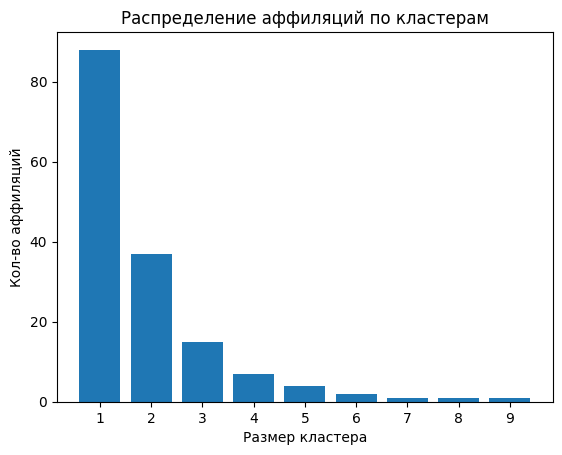

In [ ]:
dd = Counter(d.values())
dd = dict(sorted(dd.items()))
names = list(dd.keys())
values = list(dd.values())

plt.bar(range(len(dd)), values, tick_label=names)
plt.title('Распределение аффиляций по кластерам')
plt.xlabel('Размер кластера')
plt.ylabel('Кол-во аффиляций')
plt.show()

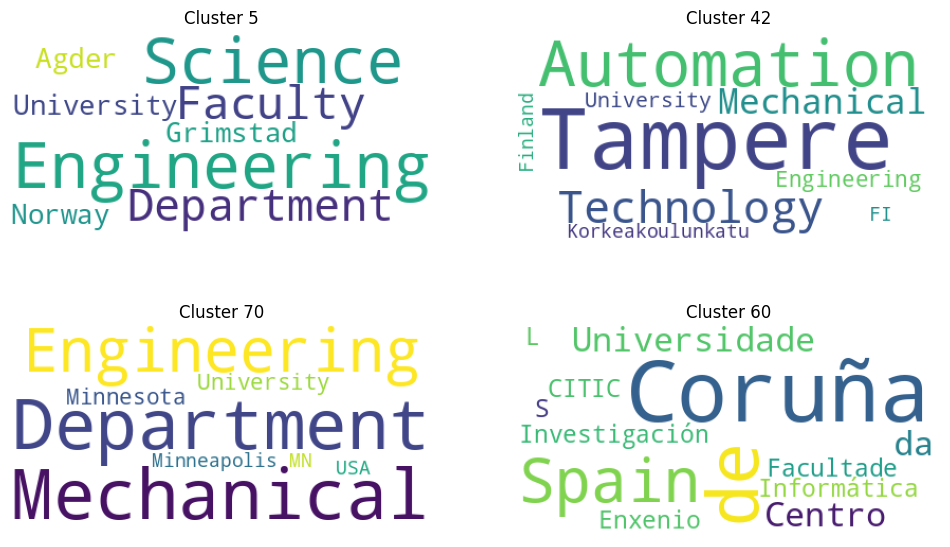

In [ ]:
# самые популярные слова в кластерах

plt.figure(figsize=(12,7))
plt.subplot(221)
plt.title('Cluster 5')
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(data['affilations'].iloc[0]))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(222)
plt.title('Cluster 42')
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(data['affilations'].iloc[1]))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(223)
plt.title('Cluster 70')
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(data['affilations'].iloc[2]))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(224)
plt.title('Cluster 60')
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(data['affilations'].iloc[3]))
plt.imshow(word_cloud)
plt.axis('off')

plt.show()

# 3-я модель – Agglomerative Clustering

**Спектральная кластеризация выполняет низкоразмерное вложение матрицы сродства между выборками.**

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(af)

In [ ]:
# Обучим модель и замерим время обучения
%%time
model = AgglomerativeClustering(n_clusters = 200)
model.fit(X.toarray())
labels = model.labels_
labels

CPU times: user 47.5 ms, sys: 0 ns, total: 47.5 ms
Wall time: 52.9 ms


array([ 13, 190, 159, 168, 119, 199,  87,   6,   3,  25,  25, 174, 122,
         2,  71, 154,  38,  16,   3, 164,  46,  35,  32,  77,  22,   8,
       117, 146,  41, 120, 150, 169,  26, 193, 149,  15, 197,  46, 180,
       114,  41,  95,  77, 147,   7,  43, 121,  19,  77,  16,  12,  12,
        12, 109, 151, 135, 143, 181, 143,  33, 102, 129, 166, 111, 160,
         3,  10,  96,  46,  25, 115,   5,  57,  37,  39,  93,   0, 153,
         0,   0,  93, 133, 100,  53,  42, 187, 184, 123, 112, 188,  40,
       172,  68,   4,  34,  34, 185, 162, 141, 183, 136, 167, 101, 182,
       152,  98, 186, 142,  54, 155, 132,  22,   4,  78,  22,   8,  19,
        95, 177,  39, 143, 191, 161, 195,   0,  71, 140, 139,  10,  96,
        53,  42,  47,  83, 165,  67,  83, 144, 144, 144,  32,  21, 137,
       108,  48,  78,  83,  83,  17,  21,  99,  79, 176,  63,  63,   4,
        70,  26,  94,  31, 110,  94,  31,   9,   9, 173,  80, 187,  40,
         1,  49,  67,  17, 158,  23, 104,  98,  48,   5,  60,  3

In [ ]:
labels.shape

(333,)

**Модель обучается в 10 раз быстрее модели k-means.**

In [ ]:
ss = metrics.silhouette_score(X, labels, metric='euclidean'); ss

0.2956104180720051

**На первый взгляд, модель подходящая, так как значение коэффициента силуэта высокое. Подберем теперь наилучшее значение количества кластеров.**

In [ ]:
list_ss = []
for k in range(100, 333, 10):
    model = AgglomerativeClustering(n_clusters = k).fit(X.toarray())
    pred_labels = model.labels_
    ss = metrics.silhouette_score(X, pred_labels, metric='euclidean')   # подсчет Silhoutte Score
    list_ss.append(ss)

Text(0, 0.5, 'Silhouette score')

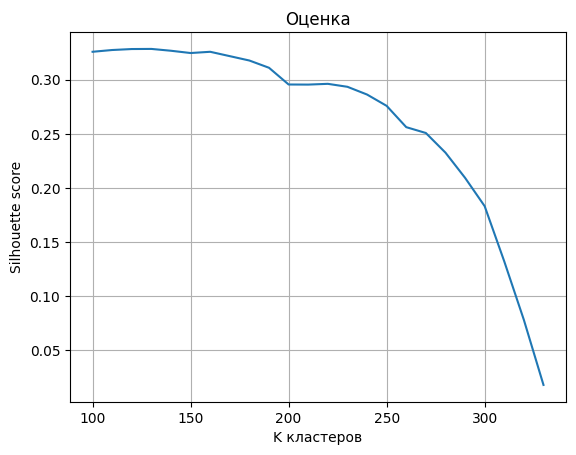

In [ ]:
plt.plot(range(100, 333, 10), list_ss)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('Silhouette score')

**Из графика выходит, что чем меньше кластеров, тем точнее работает модель. Проведем более подробное итерирование.**

In [ ]:
list_ss = []
list_dbi = []
for k in range(100, 200, 2):
    model = AgglomerativeClustering(n_clusters = k).fit(X.toarray())
    pred_labels = model.labels_
    ss = metrics.silhouette_score(X.toarray(), pred_labels, metric='euclidean')        # подсчет Silhoutte Score
    dbi = metrics.davies_bouldin_score(X.toarray(), pred_labels)         # подсчет DBI score
    list_ss.append(ss)
    list_dbi.append(dbi)

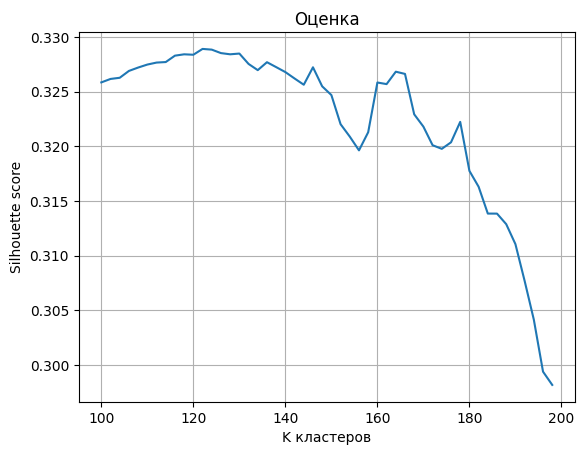

In [ ]:
plt.plot(range(100, 200, 2), list_ss)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('Silhouette score');

**Значение коэффициента силуэта держится в интервале (0,295; 0,328) от 100 кластеров до 200. Это значит, что к данной задаче модель следует применять в совокупности с другими моделями.**

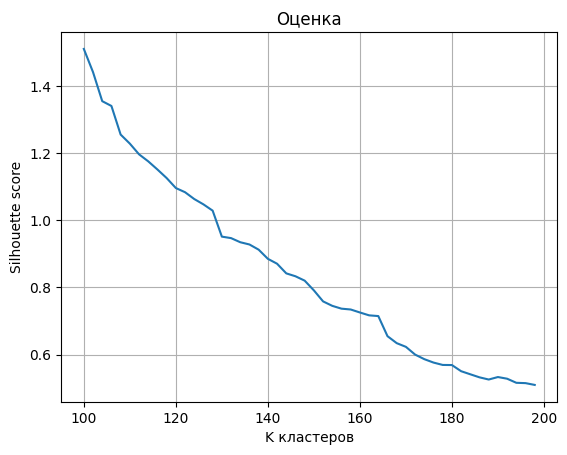

In [ ]:
plt.plot(range(100, 200, 2), list_dbi)
plt.grid()
plt.title('Оценка')
plt.xlabel('K кластеров')
plt.ylabel('Silhouette score');

**Метрика DBI ведет себя как положено.**

**Построим финальную модель AgglomerativeClustering**

In [ ]:
model = AgglomerativeClustering(n_clusters = 160).fit(X.toarray())
pred_labels = model.labels_

In [ ]:
pairs = dict(zip(af, pred_labels))

In [ ]:
import itertools
dict(itertools.islice(pairs.items(), 3))

{'Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway': 39,
 'Automation Technology and Mechanical Engineering, Tampere University, Korkeakoulunkatu 6, FI-33720, Tampere, Finland': 9,
 'Department of Mechanical Engineering, University of Minnesota, Minneapolis, MN, USA': 159}

In [ ]:
data['labels Agglomerative'] = data['affilations'].apply(lambda x: list(set([*map(pairs.get, x)])))

In [ ]:
data.iloc[:, [1, 5, 13]].head(15)   # лейблы кластеров проставлены

,title,affilations,labels Agglomerative
0,Novel concept for stabilising a hydraulic circ...,"[Faculty of Engineering and Science, Departmen...",[39]
1,Open-loop Independent Metering Control of a Mu...,[Automation Technology and Mechanical Engineer...,[9]
2,Modelling and experimental validation of the d...,"[Department of Mechanical Engineering, Univers...",[159]
3,Applying Feature-Oriented Software Development...,"[Universidade da Coruña, Centro de Investigaci...",[5]
4,DESIGN ANALYSIS AND CONTROL OF A MAGNETORHEOLO...,[Northern Arizona University - M.E. Department...,"[43, 99]"
5,Digital hydraulic multi-pressure actuator – th...,[Laboratory of Automation and Hydraulic Engine...,"[9, 38]"
6,REDUCING INFLUENCE OF ECCENTRIC LOAD ON DYNAMI...,"[SMC pneumatic technical Center, Mechanical En...",[51]
7,Model-Driven Skills Assessment in Knowledge Ma...,"[EVAL for Research Group, University of Cadiz,...",[8]
8,Method for combining valves with symmetric and...,"[LASHIP, Department of Mechanical Engineering,...",[28]
9,APPLICATION OF EXTENDED KALMAN FILTER IN A MET...,"[Rolf Fluid Power Lab, Mechanical and Aerospac...",[71]


In [ ]:
# кол-во элементов в каждом кластере
d = Counter(sorted(list(np.concatenate(list(data['labels Agglomerative'])).flat)))
dict(itertools.islice(d.items(), 20))

{0: 2,
 1: 2,
 2: 3,
 3: 3,
 4: 2,
 5: 1,
 6: 1,
 7: 3,
 8: 1,
 9: 7,
 10: 2,
 11: 1,
 12: 6,
 13: 6,
 14: 4,
 15: 6,
 16: 1,
 17: 2,
 18: 2,
 19: 2}

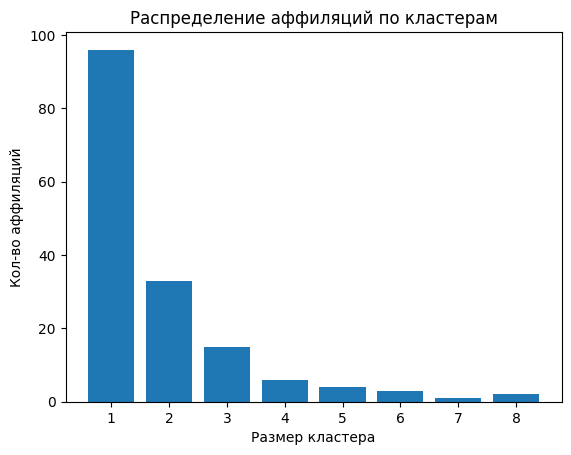

In [ ]:
dd = Counter(d.values())
dd = dict(sorted(dd.items()))
names = list(dd.keys())
values = list(dd.values())

plt.bar(range(len(dd)), values, tick_label=names)
plt.title('Распределение аффиляций по кластерам')
plt.xlabel('Размер кластера')
plt.ylabel('Кол-во аффиляций')
plt.show()

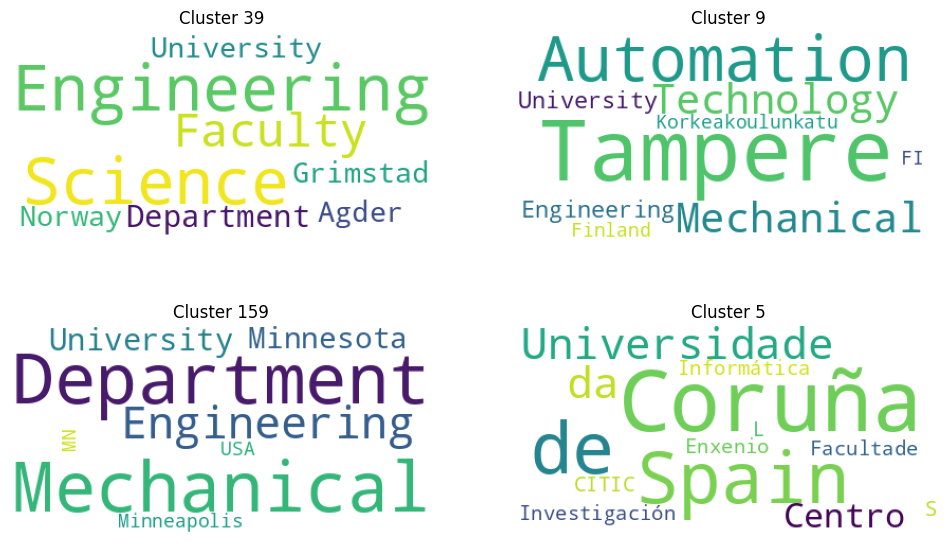

In [ ]:
# самые популярные слова в кластерах

plt.figure(figsize=(12,7))
plt.subplot(221)
plt.title('Cluster 39')
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(data['affilations'].iloc[0]))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(222)
plt.title('Cluster 9')
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(data['affilations'].iloc[1]))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(223)
plt.title('Cluster 159')
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(data['affilations'].iloc[2]))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(224)
plt.title('Cluster 5')
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(data['affilations'].iloc[3]))
plt.imshow(word_cloud)
plt.axis('off')

plt.show()

# Вывод

В ходе работы были выполнены все поставленные задачи: \
1. Добыча данных;
2. Выделение нужной информации и ее подотовка;
3. Кластеризация аффиляций. \

Модель k-means, наиболее времязатратная и ресурсозатратная, показала наилучшие результаты. Однако другие модели тоже справляются с задачей, если четко знать, на какое количество кластеров требуется разбить аффиляции.